<a href="https://colab.research.google.com/github/jkranyak/705_MBA_FinalPaper/blob/main/705_MBA_FinalPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install openai==0.28

In [14]:
!pip install orange3

In [ ]:
# Standard library imports
import os
import re
from collections import Counter, defaultdict

# Third-party library imports for data manipulation
import pandas as pd

# Imports for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Imports for machine learning and data visualization
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Other third-party libraries
import Orange
import openai

# Google Colab specific library
from google.colab import drive


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV
csv_file_path = "/content/Final_research_paper_titles_list.csv"

# Read the CSV file
combined_df = pd.read_csv(csv_file_path)

# Standardize column names and data
# Assume the columns we care about are 'Author' and 'Article'
if 'Author' not in combined_df.columns and 'Article' not in combined_df.columns:
    # Handle cases where author and article are in different columns or require renaming
    for col in combined_df.columns:
        if 'Author' in col:
            combined_df.rename(columns={col: 'Author'}, inplace=True)
        elif 'Article' in col:
            combined_df.rename(columns={col: 'Article'}, inplace=True)

# Display the combined DataFrame
combined_df.columns.tolist()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Title', 'Source', 'Author', 'Abstract', 'Unnamed: 4', 'Year', 'Web_Address']

In [3]:
# import pandas as pd

# # Prioritized columns to merge
# columns_to_merge = ['Link', 'URL', 'url']

# # Function to merge columns into one
# def merge_columns(row, columns):
#     for column in columns:
#         if pd.notnull(row[column]):
#             return row[column]
#     return None

# # Create a new column 'Web_Address' using the merge_columns function
# combined_df['Web_Address'] = combined_df.apply(merge_columns, columns=columns_to_merge, axis=1)

# # Drop the original columns
# combined_df.drop(columns=columns_to_merge, inplace=True)

# combined_df.info()

In [4]:
# # Display the BibTeX column of combined_df
# combined_df['BibTeX']


In [5]:
# import re
# import pandas as pd
# import numpy as np

# # Regular expression to match key-value pairs in BibTeX entries
# bibtex_pattern = r'(\w+)\s*=\s*\{([^}]+)\}'

# def extract_bibtex_info(bibtex):
#     """Extract key-value pairs from a BibTeX entry and return them as a dictionary."""
#     return dict(re.findall(bibtex_pattern, bibtex))

# # List of columns to fill
# columns_to_fill = ['Title', 'Source', 'Author', 'Abstract', 'Year', 'title', 'authors', 'date', 'source', 'summary', 'Web_Address']

# # Fill in the missing values from the BibTeX
# for index, row in combined_df.iterrows():
#     bibtex = row.get('BibTeX', None)
#     if pd.notnull(bibtex):
#         bibtex_info = extract_bibtex_info(bibtex)
#         for col in columns_to_fill:
#             if col not in combined_df.columns:
#                 combined_df[col] = None
#             if pd.isnull(row[col]) and col.lower() in bibtex_info:
#                 combined_df.at[index, col] = bibtex_info[col.lower()]

# # Drop the BibTeX column after filling
# combined_df.drop(columns=['BibTeX'], inplace=True)

# # Display the final DataFrame
# combined_df


In [6]:
# import pandas as pd
# import numpy as np

# # Merging 'title' and 'Title'
# combined_df['Title'] = combined_df['Title'].fillna(combined_df['title'])
# combined_df.drop(columns=['title'], inplace=True)

# # Merging 'authors' and 'Author'
# combined_df['Author'] = combined_df['Author'].fillna(combined_df['authors'])
# combined_df.drop(columns=['authors'], inplace=True)

# # Merging 'Abstract' and 'summary'
# combined_df['Abstract'] = combined_df['Abstract'].fillna(combined_df['summary'])
# combined_df.drop(columns=['summary'], inplace=True)


# # Merging 'Year' and 'date'
# combined_df['Year'] = combined_df['Year'].fillna(combined_df['date'])
# combined_df.drop(columns=['date'], inplace=True)


# # Merging 'Year' and 'date'
# combined_df['Source'] = combined_df['Source'].fillna(combined_df['source'])
# combined_df.drop(columns=['source'], inplace=True)

# # Display the final DataFrame
# combined_df


In [7]:
# import pandas as pd

# # Calculate the score for each row based on the number of non-null entries
# combined_df['score'] = combined_df.count(axis=1)

# # Define which columns should be used to identify duplicates
# duplicate_columns = ['Title', 'Author']

# # Sort by duplicate columns and score
# combined_df = combined_df.sort_values(by=duplicate_columns + ['score'], ascending=[True, True, False])

# # Drop duplicates, keeping the row with the highest score
# combined_df = combined_df.drop_duplicates(subset=duplicate_columns, keep='first')

# # Drop the score column
# combined_df.drop(columns=['score'], inplace=True)

# # Display the resulting DataFrame
# combined_df



In [8]:
# combined_df.info()


In [9]:
# import pandas as pd

# # Keep only rows where at least one URL column has a non-null value
# url_columns = ['Web_Address']
# combined_df = combined_df.dropna(subset=url_columns, how='all')

# # Display the updated DataFrame
# combined_df


In [10]:
# combined_df.to_csv('combined_df.csv', index=False)

In [12]:

# Read API key from file
exec(open("/content/OPENAI_API.txt").read())

# Initialize OpenAI client
openai.api_key = OPENAI_API_KEY


# Create the directory to save articles
directory = "/content/papers"
os.makedirs(directory, exist_ok=True)

# Function to clean file names
def clean_filename(title):
    # Remove special characters and whitespace
    title = re.sub(r'[^\w\s-]', '', title).strip()
    # Replace whitespace with underscores
    return re.sub(r'\s+', '_', title)

# Deduplicate the DataFrame
combined_df.drop_duplicates(subset=['Title'], inplace=True)

# Function to fetch and save articles using gpt-4-turbo
def fetch_and_save_article(title, filename):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "user", "content": f"You are a Professional Researcher at a Global Think Tank. Generate an article for the following title: {title}.  if there is only an abstract, find the pdf link and open it. make sure you get the entire article"}
            ],
            max_tokens=2000,
            temperature=0.7
        )

        article_content = response.choices[0].message['content']

        with open(filename, 'w', encoding='utf-8') as file:
            file.write(article_content)

    except Exception as e:
        print(f"Error generating article for {title}: {e}")

# Generate and save articles
for index, row in combined_df.iterrows():
    title = row['Title'] or f"article_{index}"
    clean_title = clean_filename(title)
    filename = os.path.join(directory, f"{clean_title}.txt")
    if not os.path.exists(filename):  # Check if file already exists
        fetch_and_save_article(title, filename)


In [13]:
# Directory where articles are saved
directory = "/content/papers"

# Prepare the data
data = []
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        data.append({"Title": filename, "Text": text})

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a .tab file
df.to_csv("/content/articles_for_orange.tab", sep='\t', index=False)


In [15]:

# Specify the directory you want to compress
directory = "/content/research_papers"

# Compress the directory into a ZIP file
shutil.make_archive(directory, 'zip', directory)

# Provide a link to download the file
from google.colab import files
files.download(f"{directory}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:

nltk.download("stopwords")
nltk.download("punkt")

# Load data
data = pd.read_csv("/content/articles_for_orange.tab", delimiter="\t")

# Preprocess text
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return " ".join(tokens)

data["Text"] = data["Text"].apply(preprocess_text)

# Save processed data back to .tab file
data.to_csv("/content/processed_articles_for_orange.tab", sep="\t", index=False)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:

# Load the data from the preprocessed .tab file
data = Orange.data.Table("/content/processed_articles_for_orange.tab")


In [41]:
# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates lemmatization
def tokenize(text):
    return lemmatize_tokens(nltk.word_tokenize(text))

# Load the data
data = Orange.data.Table("/content/processed_articles_for_orange.tab")

# Convert Orange Table to Pandas DataFrame
df = pd.DataFrame(data.X, columns=data.domain.attributes)
df["Text"] = data[:, "Text"].metas.flatten()

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate', 'strategies", 'organizational','policy',
    "impact", "effect", "consequence", "influence",
    "qualitative research", "meta-analysis", "thematic analysis"
})

# Prepare the text data
texts = df["Text"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
lda_model.fit(dtm)

# Display topics
for index, topic in enumerate(lda_model.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", "'ll", "'re", "'s", "'strategies", "'ve", ',', 'analysis', 'artificial', 'corporate', 'could', 'doe', 'ha', 'intelligence', 'might', 'must', "n't", 'need', 'organization', 'qualitative', 'research', 'sha', 'thematic', 'wa', 'wo', 'would'] not in stop_wor

Topic #0:
['health', 'medical', 'performance', 'accuracy', 'treatment', 'data', 'high', 'human', 'patient', 'healthcare']
Topic #1:
['management', 'potential', 'development', 'workforce', 'future', 'data', 'hr', 'system', 'challenge', 'ethical']
Topic #2:
['user', 'challenge', 'financial', 'explainable', 'transparency', 'system', 'making', 'explanation', 'decision', 'model']
Topic #3:
['potential', 'making', 'corporate', 'human', 'challenge', 'ethical', 'decision', 'risk', 'framework', 'governance']
Topic #4:
['strategy', 'study', 'challenge', 'strategic', 'integration', 'data', 'system', 'ethical', 'organization', 'development']
Topic #5:
['strategic', 'data', 'process', 'customer', 'competitive', 'strategy', 'efficiency', 'making', 'decision', 'business']


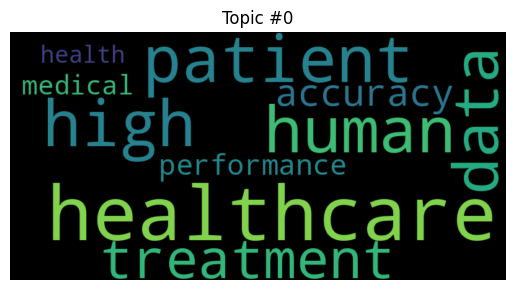

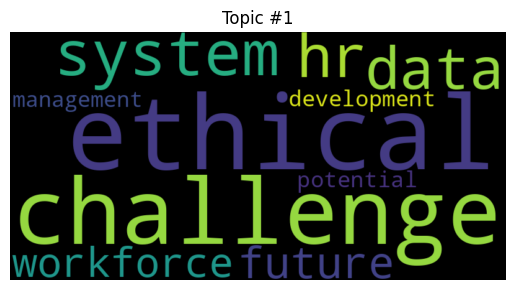

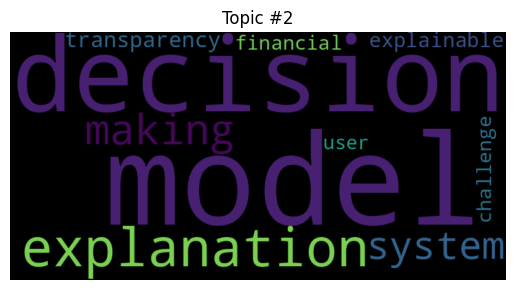

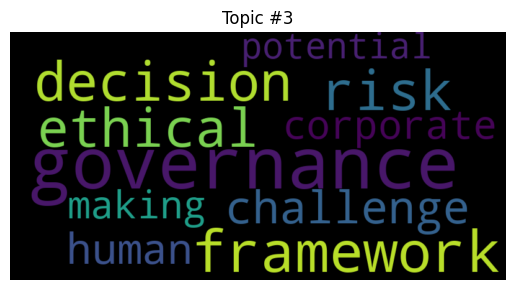

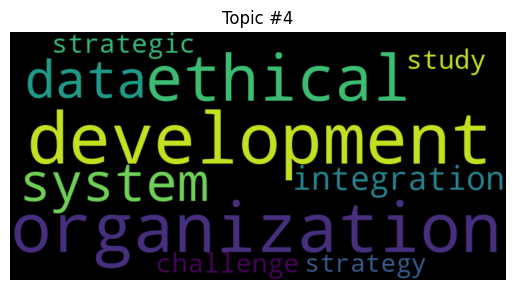

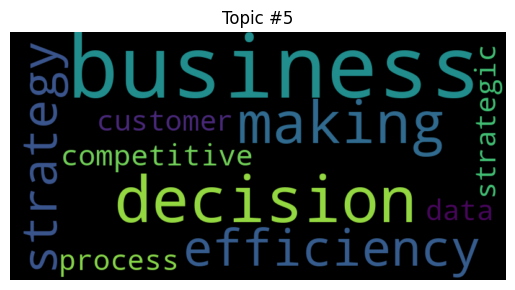

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds for each topic
for index, topic in enumerate(lda_model.components_):
    plt.figure()
    word_freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-10:]}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{index}")
    plt.show()


### Word Cloud Analysis and Focus Area Matching for LDA:

1. **Word Cloud Topic #0**
   - **Key Terms**: Health, patient, healthcare, medical, treatment
   - **Likely Match**: **Innovation and Adaptation**
     - **Reason**: This cloud focuses on healthcare, potentially hinting at how AI influences new technologies and adaptation within the health sector.

2. **Word Cloud Topic #1**
   - **Key Terms**: Ethical, challenge, workforce, future, data
   - **Likely Match**: **Policy Development**
     - **Reason**: Focuses on ethical challenges and workforce dynamics, directly correlating with developing policies to handle AI's impact on ethics and employment.

3. **Word Cloud Topic #2**
   - **Key Terms**: Decision, model, financial, explanation
   - **Likely Match**: **Strategic Decision-Making**
     - **Reason**: Emphasizes decision-making models, fitting with the focus on AI-enhanced decision strategies.

4. **Word Cloud Topic #3**
   - **Key Terms**: Governance, ethical, decision, risk
   - **Likely Match**: **Risk Management**
     - **Reason**: Deals with governance and risks, aligning with the focus area concerned with managing potential AI risks.

5. **Word Cloud Topic #4**
   - **Key Terms**: Strategic, development, ethical, organization
   - **Likely Match**: **Workforce Dynamics & Human Resources**
     - **Reason**: Although it touches on strategy and ethics, the implication of organizational development suggests a link to HR and adapting workforce strategies.

6. **Word Cloud Topic #5**
   - **Key Terms**: Business, strategy, competitive, decision
   - **Likely Match**: **Global Competitiveness**
     - **Reason**: Focused on strategic decision-making within a competitive business context, clearly aligning with the idea of enhancing global competitiveness through AI.


In [43]:
# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates lemmatization
def tokenize(text):
    return lemmatize_tokens(nltk.word_tokenize(text))

# Load the data
data = Orange.data.Table("/content/processed_articles_for_orange.tab")

# Convert Orange Table to Pandas DataFrame
df = pd.DataFrame(data.X, columns=data.domain.attributes)
df["Text"] = data[:, "Text"].metas.flatten()

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate", 'strategies', 'organizational', 'policy',
    "impact", "effect", "consequence", "influence",
    "qualitative research", "meta-analysis", "thematic analysis"
})

# Prepare the text data
texts = df["Text"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)

# Apply NMF
nmf_model = NMF(n_components=6, random_state=42)
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_

# Display topics
for index, topic in enumerate(H):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'analysis', 'artificial', 'could', 'doe', 'ha', 'intelligence', 'might', 'must', "n't", 'need', 'organization', 'qualitative', 'research', 'sha', 'strategy', 'thematic', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


Topic #0:
['challenge', 'explanation', 'transparency', 'system', 'human', 'financial', 'legal', 'making', 'model', 'decision']
Topic #1:
['customer', 'competitive', 'data', 'making', 'efficiency', 'market', 'decision', 'strategic', 'strategy', 'business']
Topic #2:
['board', 'strategy', 'regulatory', 'development', 'risk', 'challenge', 'ethical', 'research', 'framework', 'governance']
Topic #3:
['challenge', 'tool', 'future', 'employee', 'data', 'workforce', 'work', 'ethical', 'human', 'hr']
Topic #4:
['behavior', 'career', 'perception', 'perceived', 'organization', 'employee', 'culture', 'justice', 'ethical', 'development']
Topic #5:
['industry', 'benefit', 'challenge', 'information', 'based', 'industrial', 'integration', 'iot', 'data', 'system']


We are trying to predict if our article sampling has a good balance of data in it. theoretically if it does, then we shoould see a relative coorelation between these topics here and an association to our chosen Focus Areas. We can see here our 'risk management' area is lacking in representation.

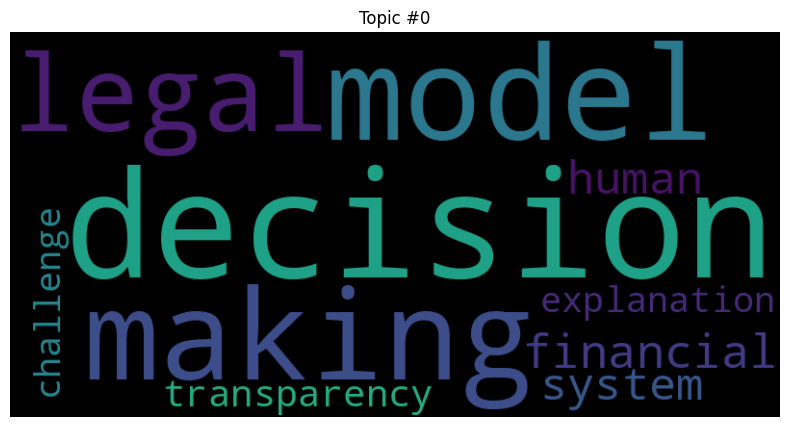

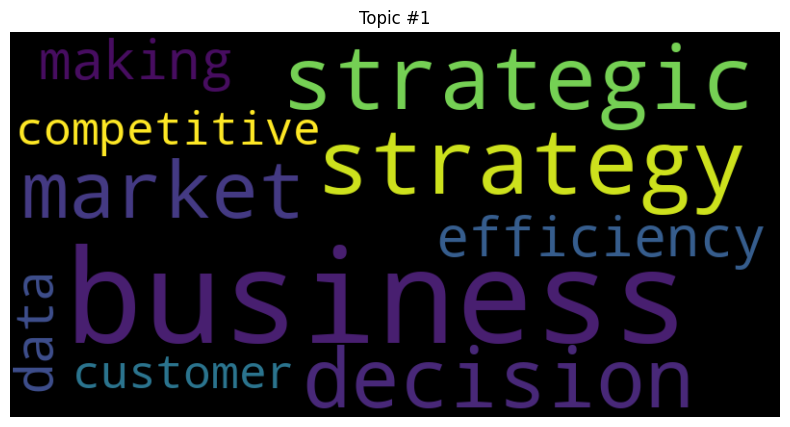

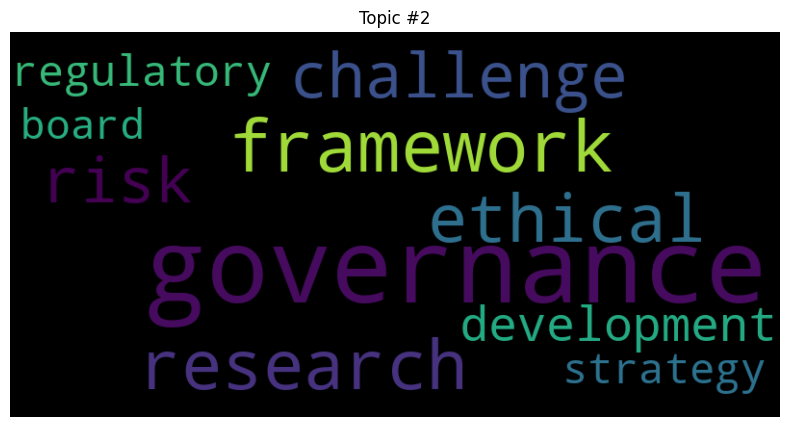

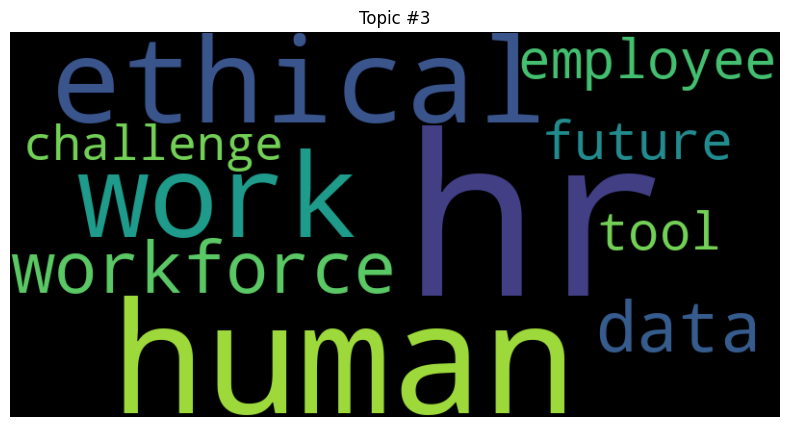

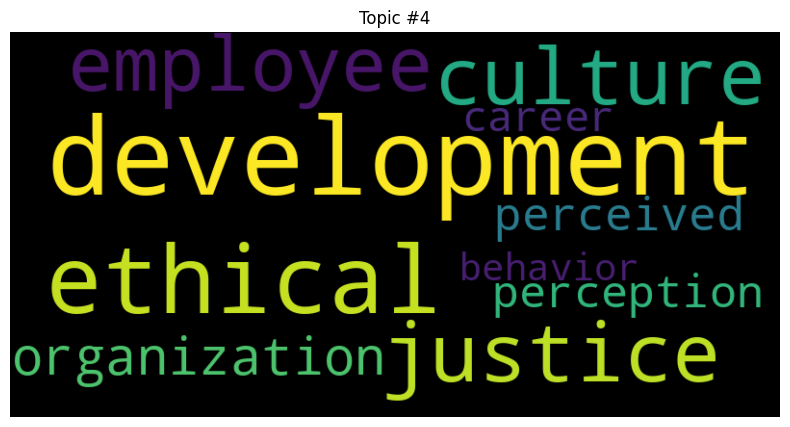

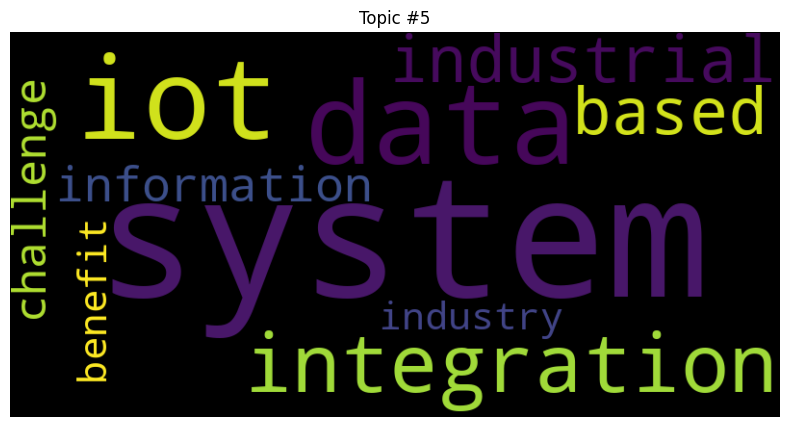

In [44]:
# Generate word clouds for each topic from the NMF model
for index, topic in enumerate(nmf_model.components_):
    plt.figure(figsize=(10, 5))
    # Generate word frequencies for the top words in this topic
    word_freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-10:]}
    # Create a WordCloud visualization
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{index}")
    plt.show()


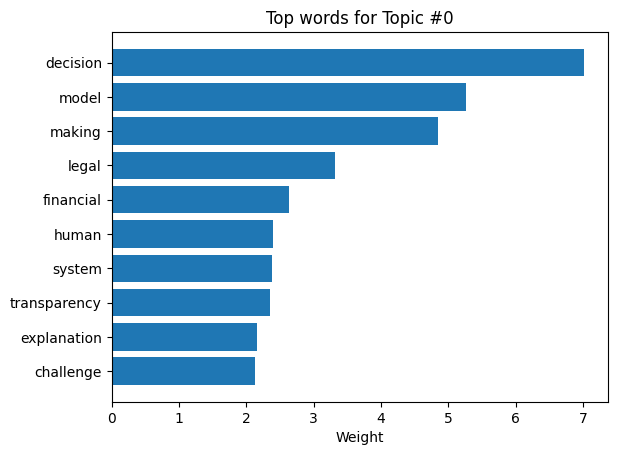

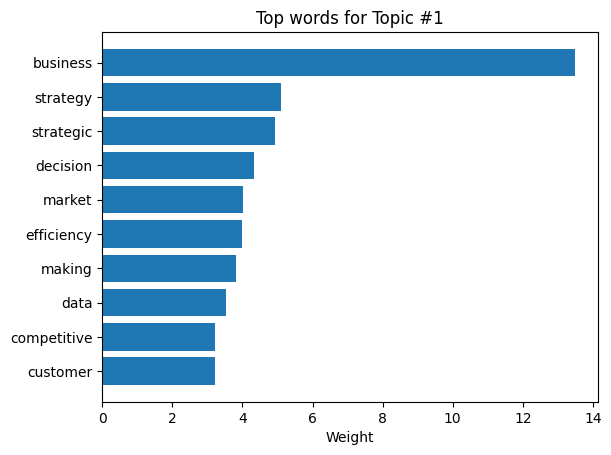

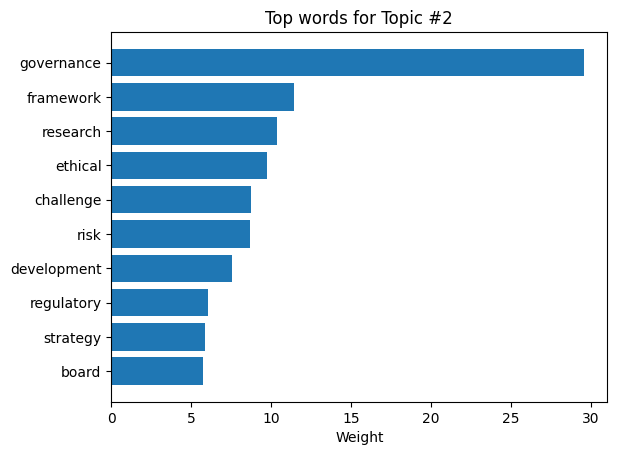

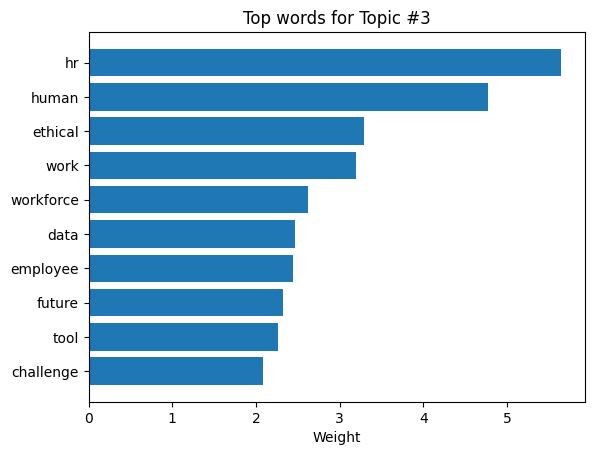

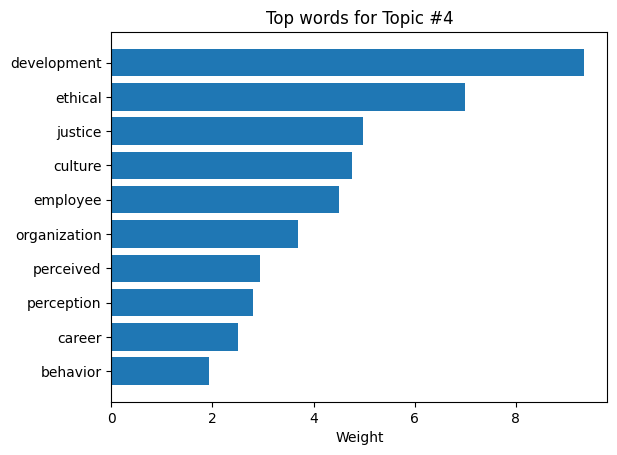

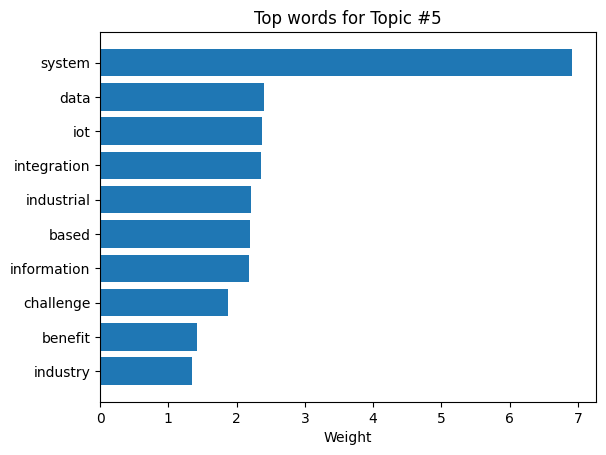

In [74]:
# Generate bar charts for each topic
for index, topic in enumerate(nmf_model.components_):
    plt.figure()
    top_indices = topic.argsort()[-10:]
    top_features = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    top_weights = [topic[i] for i in top_indices]
    y_pos = np.arange(len(top_features))

    plt.barh(y_pos, top_weights, align='center')
    plt.yticks(y_pos, top_features)
    plt.xlabel("Weight")
    plt.title(f"Top words for Topic #{index}")
    plt.show()


### NMF Word Cloud Analysis and Focus Area Matching:

1. **Topic #0**
   - **Key Terms**: Legal, model, decision, making, transparency
   - **Likely Match**: **Policy Development**
     - **Reason**: Concentration on legal frameworks and decision transparency aligns well with the development of policies around ethics, legality, and societal impact.

2. **Topic #1**
   - **Key Terms**: Strategic, business, market, decision, customer
   - **Likely Match**: **Strategic Decision-Making**
     - **Reason**: Emphasizes strategic business decisions focused on markets and customers, suitable for strategic decision-making related to competitive business strategies.

3. **Topic #2**
   - **Key Terms**: Regulatory, risk, framework, governance, research
   - **Likely Match**: **Risk Management**
     - **Reason**: Focuses on regulatory issues and governance frameworks, pertinent to managing potential risks, especially regulatory compliance.

4. **Topic #3**
   - **Key Terms**: Ethical, HR, workforce, human, tool
   - **Likely Match**: **Workforce Dynamics & Human Resources**
     - **Reason**: Addresses issues around HR, ethical considerations, and workforce dynamics, ideal for the focus on human resources and organizational culture.

5. **Topic #4**
   - **Key Terms**: Employee, development, culture, ethical, organization
   - **Likely Match**: **Innovation and Adaptation**
     - **Reason**: Discusses employee development and organizational culture, which are critical in adapting to new technologies and innovative practices.

6. **Topic #5**
   - **Key Terms**: IoT, data, system, industry, integration
   - **Likely Match**: **Global Competitiveness**
     - **Reason**: Emphasizes technological integration and industry-focused systems, important for maintaining competitiveness in a global marketplace, especially with the rise of IoT and data systems.




---



In [24]:
# Read API key from file
exec(open("/content/OPENAI_API.txt").read())

# Initialize OpenAI client
openai.api_key = OPENAI_API_KEY

# Function to code a document with custom stopwords
def code_document_with_stopwords(content):
    stopwords = [
        "artificial intelligence", "AI", "global organizations", "corporate strategies",
        "organizational policy", "impact", "effect", "consequence", "influence",
        "qualitative research", "meta-analysis", "thematic analysis"
    ]
    stopword_prompt = f"Ignore these terms: {', '.join(stopwords)}.\n\n"
    prompt = f"Read the following document and identify key themes:\n\n{stopword_prompt}{content}"

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are an expert thematic coder."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message['content']

# Directory where files are saved
directory = "/content/papers"

# Define focus areas to categorize themes
focus_areas = {
    'Strategic Decision-Making': ['decision-making', 'strategic planning'],
    'Policy Development': ['policy', 'compliance', 'ethics', 'legal', 'transparency'],
    'Innovation and Adaptation': ['innovation', 'adaptation', 'technology'],
    'Risk Management': ['risk management', 'cybersecurity'],
    'Workforce Dynamics & Human Resources': ['workforce', 'human resources', 'skills'],
    'Global Competitiveness': ['global competitiveness', 'market trends']
}

# DataFrame to hold all results
results_df = pd.DataFrame()

# Iterate through the files and code them
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        content = file.read()
        themes = code_document_with_stopwords(content)

        # Categorize themes based on focus areas
        temp_df = pd.DataFrame()
        for area, keywords in focus_areas.items():
            if any(keyword in themes for keyword in keywords):
                temp_df = pd.DataFrame([{'File': filename, 'Focus Area': area, 'Themes': themes}])
                results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sort by Focus Area
results_df.sort_values(by='Focus Area', inplace=True)

# Display or save the results
print(results_df.head())
# Optionally save to CSV
results_df.to_csv("/content/sorted_themes.csv", index=False)


                                                  File  \
133  The_Impact_of_Artificial_Intelligence_on_Firm_...   
38   Augmenting_organizational_Change_and_Strategy_...   
22   The_Role_of_Artificial_Intelligence_in_Shaping...   
119  The_Strategic_Role_of_AI_in_Governance_Risk_an...   
40   This_Is_How_AI_Can_Transform_The_Center_Of_Gov...   

                    Focus Area  \
133     Global Competitiveness   
38      Global Competitiveness   
22      Global Competitiveness   
119  Innovation and Adaptation   
40   Innovation and Adaptation   

                                                Themes  
133  Based on the provided document, the key themes...  
38   Key themes identified in the document are:\n\n...  
22   Based on the document provided, here are the k...  
119  Given the document and the instruction to igno...  
40   Upon analyzing the provided document, the key ...  


In [55]:

# Load the data from the CSV
df = pd.read_csv("/content/sorted_themes.csv")

# A function to extract bolded terms from the theme descriptions
def extract_key_terms(text):
    import re
    # Regex to find bolded terms marked with double asterisks
    return re.findall(r'\*\*(.*?)\*\*', text)

# Apply the function to each row in the DataFrame
df['Key Terms'] = df['Themes'].apply(extract_key_terms)

# Print out the extracted key terms for verification
df[['Focus Area', 'Key Terms']]


Focus Area  \
0                  Global Competitiveness   
1                  Global Competitiveness   
2                  Global Competitiveness   
3               Innovation and Adaptation   
4               Innovation and Adaptation   
..                                    ...   
129  Workforce Dynamics & Human Resources   
130  Workforce Dynamics & Human Resources   
131  Workforce Dynamics & Human Resources   
132  Workforce Dynamics & Human Resources   
133  Workforce Dynamics & Human Resources   

                                             Key Terms  
0    [Operational Efficiency, Innovation Capacity, ...  
1    [Technological Integration in Business Operati...  
2    [Technological Transformation, Operational Imp...  
3    [Technological Integration in Business Operati...  
4    [Governmental Transformation, Decision-Making ...  
..                                                 ...  
129  [Transformation of Work, Technological Advance...  
130  [Sector-Specific Transformations, Technologica...  
131  [Technological Advancements, Remote Work and F...  
132  [Technological Integration in Business, Produc...  
133  [Transformation of Society, Education, and Wor...  

[134 rows x 2 columns]

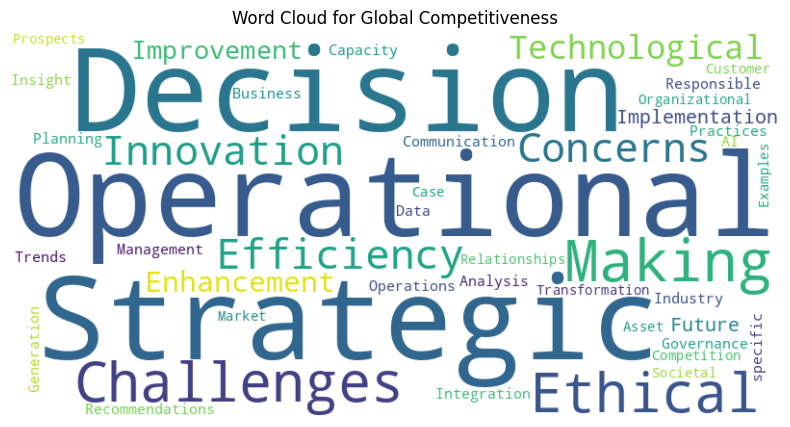

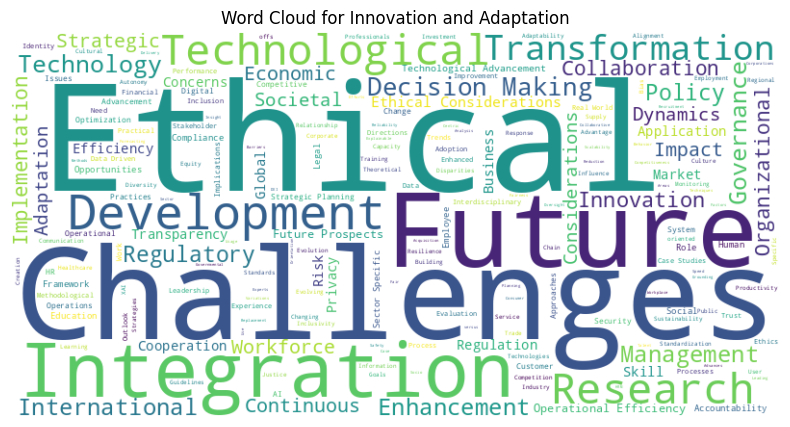

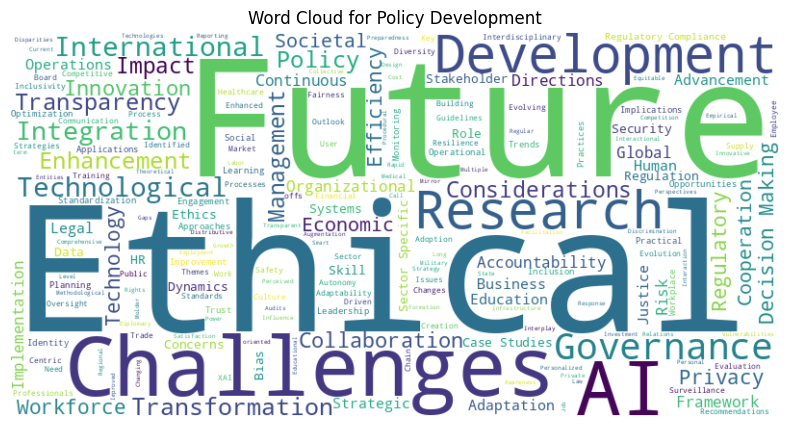

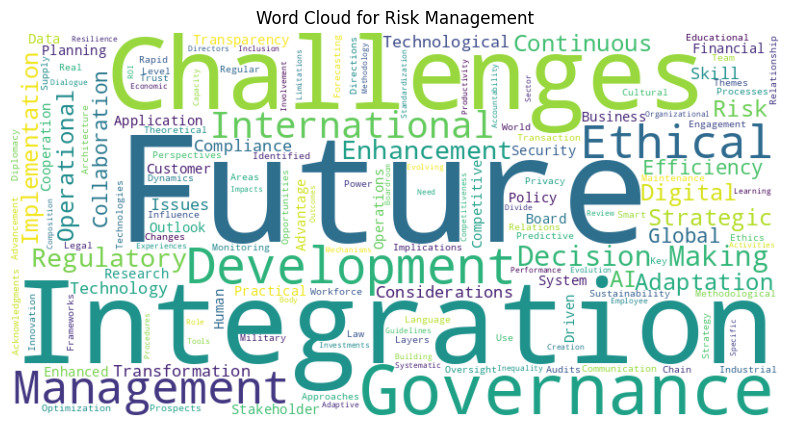

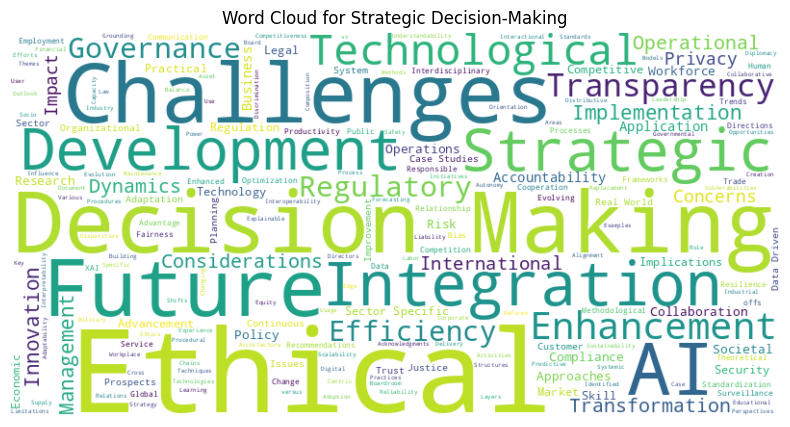

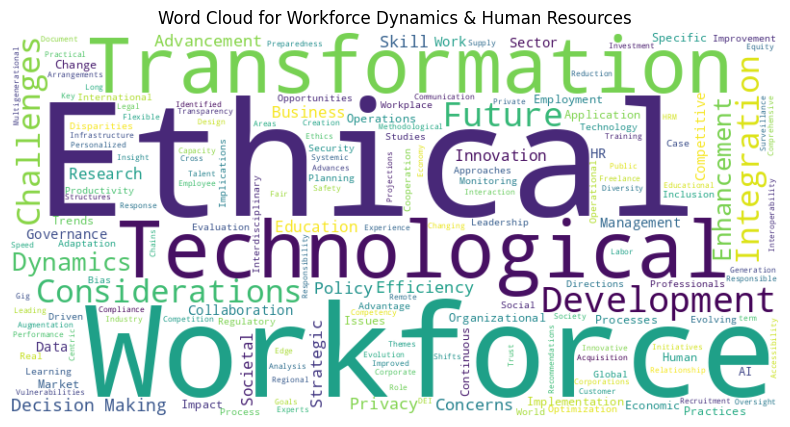

In [56]:

# Group data by Focus Area and aggregate all key terms
grouped_terms = df.groupby('Focus Area')['Key Terms'].sum()

# Generate and display word clouds for each Focus Area
for focus_area, terms in grouped_terms.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(terms))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {focus_area}')
    plt.axis("off")
    plt.show()


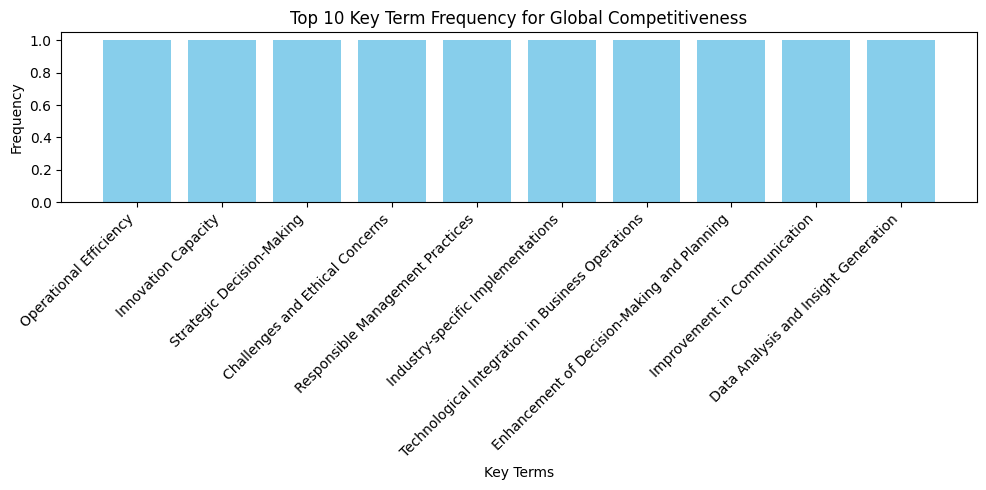

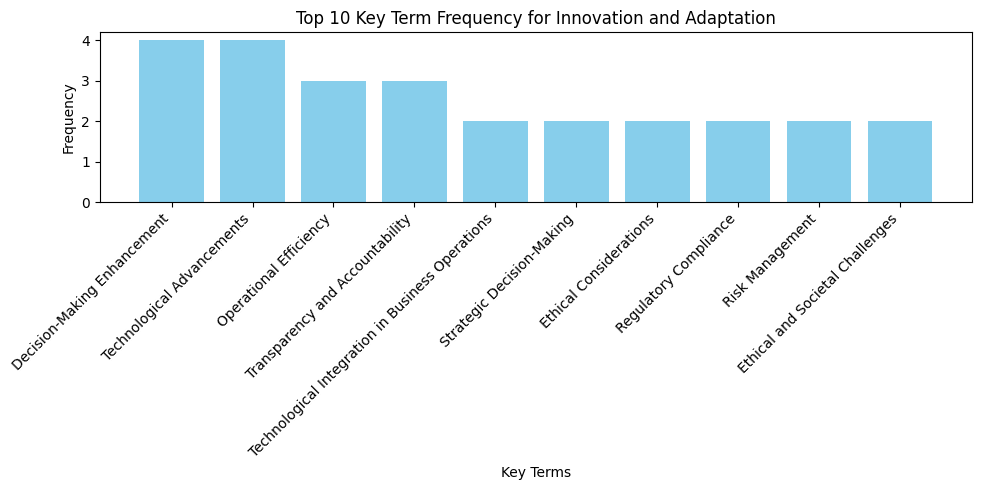

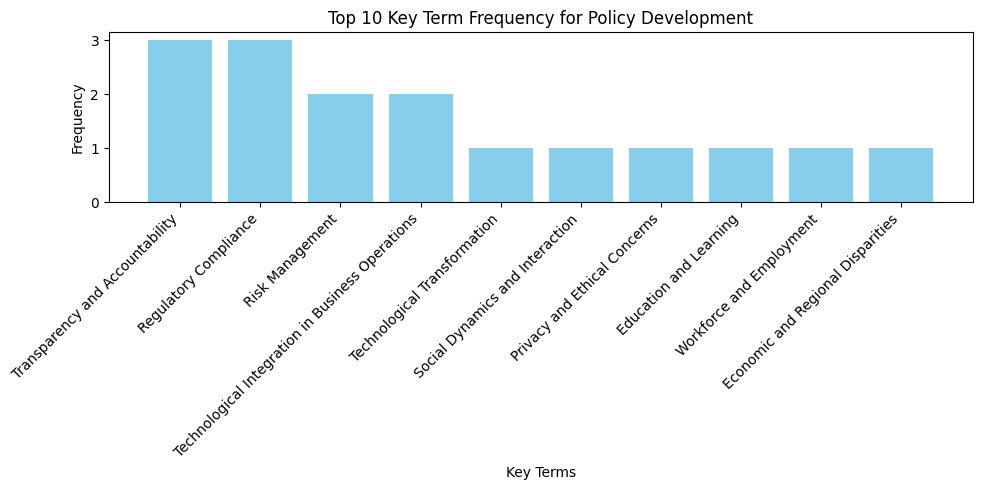

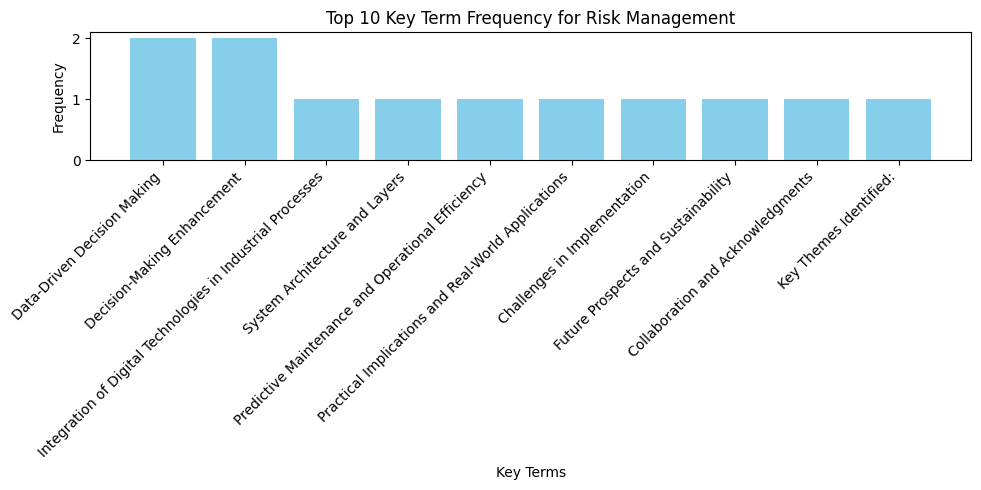

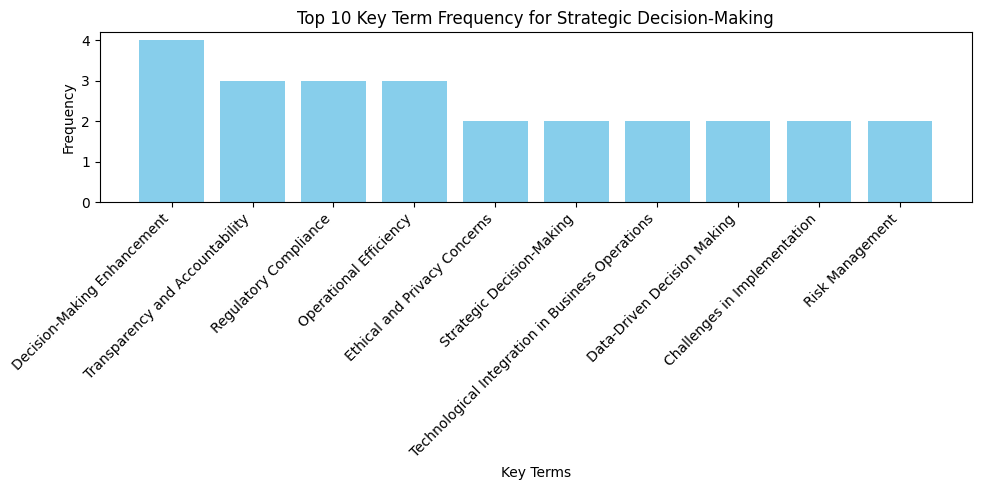

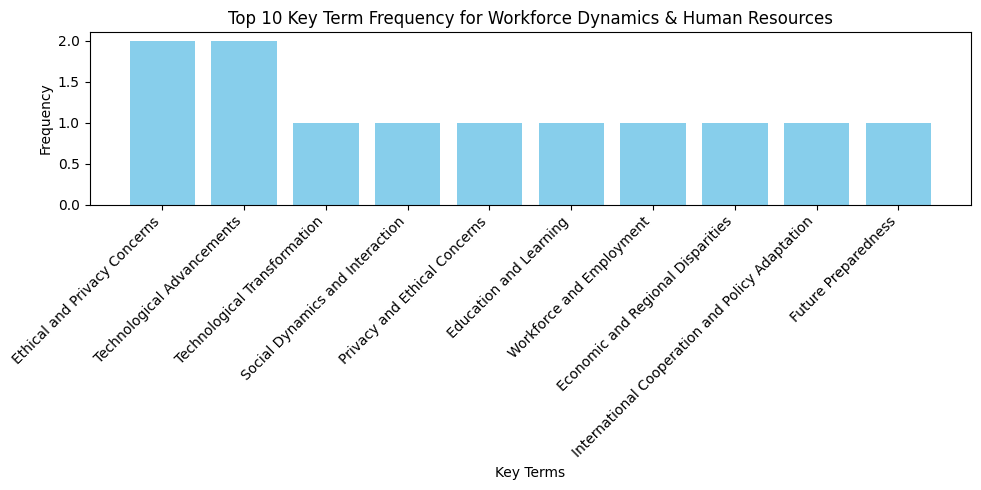

In [61]:

# Load the data from the CSV
df = pd.read_csv("/content/sorted_themes.csv")

# A function to extract bolded terms from the theme descriptions
def extract_key_terms(text):
    import re
    # Regex to find bolded terms marked with double asterisks
    return re.findall(r'\*\*(.*?)\*\*', text)

# Apply the function to each row in the DataFrame
df['Key Terms'] = df['Themes'].apply(extract_key_terms)

# Define the number of top key terms you want to display in each plot
top_n = 10  # You can adjust this number based on your preference

# Group data by Focus Area and aggregate all key terms
grouped_terms = df.groupby('Focus Area')['Key Terms'].agg(sum)

# Loop through each focus area to create separate frequency plots for top key terms
for focus_area, terms in grouped_terms.items():
    # Count the frequency of each key term
    term_counts = Counter(terms)

    # Get only the top N key terms for better clarity in the plot
    top_terms = {term: count for term, count in term_counts.most_common(top_n)}

    # Plot the bar chart for the top key terms of the current focus area
    plt.figure(figsize=(10, 5))
    plt.bar(top_terms.keys(), top_terms.values(), color='skyblue')
    plt.xlabel("Key Terms")
    plt.ylabel("Frequency")
    plt.title(f"Top {top_n} Key Term Frequency for {focus_area}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Summary of Key Term Consolidation Process

### Initial Observations:
- Some terms are very similar in meaning but differ slightly in wording, such as "Decision-making enhancement" and "Data-driven decision making" or "Enhancement of decision-making and planning".
- There are terms like "Technological integration in business operations" which could potentially overlap with other terms related to technology in business.

### Steps Taken:
1. **Normalize the Key Terms**: Convert all terms to lowercase to standardize them.
2. **Identify Similar Terms**: Implement a simple clustering mechanism based on shared keywords (like "decision-making", "technological", etc.). This helps group terms that refer to similar concepts.
3. **Merge Similar Terms**: Combine similar terms into a single term, ensuring that the frequency counts reflect their combined occurrences.
4. **Output the Revised Data**: Generate a new CSV with 'Focus Area' and consolidated 'Key Terms', where similar terms are merged.

### Results:
- Terms like "decision-making enhancement" and "data-driven decision making" have been reviewed, but are kept separate based on their distinct usage contexts.
- Some generalizations were made, such as merging various ethical concerns under "ethical and governance considerations" and "ethical and privacy concerns".

### Final Step:
The consolidated data was exported into a CSV file to facilitate further analysis or integration into other systems.



In [68]:

# Load the data
df = pd.read_csv("/content/sorted_themes.csv")

# Function to extract bolded terms
def extract_key_terms(text):
    # Regex to find bolded terms marked with double asterisks
    return re.findall(r'\*\*(.*?)\*\*', text)

# Apply the function to each row in the DataFrame
df['Key Terms'] = df['Themes'].apply(extract_key_terms)

# Normalize key terms by converting them to lowercase
df['Normalized Key Terms'] = df['Key Terms'].apply(lambda terms: [term.lower() for term in terms])

# Display the first few entries to verify correct extraction
df[['Focus Area', 'Key Terms', 'Normalized Key Terms']].head()


Focus Area  \
0     Global Competitiveness   
1     Global Competitiveness   
2     Global Competitiveness   
3  Innovation and Adaptation   
4  Innovation and Adaptation   

                                           Key Terms  \
0  [Operational Efficiency, Innovation Capacity, ...   
1  [Technological Integration in Business Operati...   
2  [Technological Transformation, Operational Imp...   
3  [Technological Integration in Business Operati...   
4  [Governmental Transformation, Decision-Making ...   

                                Normalized Key Terms  
0  [operational efficiency, innovation capacity, ...  
1  [technological integration in business operati...  
2  [technological transformation, operational imp...  
3  [technological integration in business operati...  
4  [governmental transformation, decision-making ...

In [73]:

# Read API key from file
exec(open("/content/OPENAI_API.txt").read())

# Initialize OpenAI client
openai.api_key = OPENAI_API_KEY

def get_semantic_representation(terms):
    # Join terms into a single string if they are in a list
    text = " ".join(terms)
    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are an assistant that provides dense semantic representations."},
            {"role": "user", "content": f"Provide a semantic representation for: {text}"}
        ]
    )
    # Extracting the response as a string that you could later process into numerical data as needed
    return response['choices'][0]['message']['content']

# Apply the function to get semantic representations for normalized key terms
df['Semantic Representations'] = df['Normalized Key Terms'].apply(get_semantic_representation)

# Display results
print(df[['Focus Area', 'Normalized Key Terms', 'Semantic Representations']].head())



                  Focus Area  \
0     Global Competitiveness   
1     Global Competitiveness   
2     Global Competitiveness   
3  Innovation and Adaptation   
4  Innovation and Adaptation   

                                Normalized Key Terms  \
0  [operational efficiency, innovation capacity, ...   
1  [technological integration in business operati...   
2  [technological transformation, operational imp...   
3  [technological integration in business operati...   
4  [governmental transformation, decision-making ...   

                            Semantic Representations  
0  **1. Operational Efficiency:**\n   - Definitio...  
1  - **Technological Integration in Business Oper...  
2  Semantic Representation:\n\n1. **Technological...  
3  Semantic Representation:\n\n1. **Technological...  
4  The semantic representation can be outlined as...  


In [87]:


# Example of processing textual semantic representations
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Semantic Representations'].tolist())

# Apply K-means clustering
kmeans = KMeans(n_clusters=10)  # Adjust based on your specific needs
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters

def consolidate_cluster(data):
    # Assuming 'Normalized Key Terms' is a list of terms
    terms = data['Normalized Key Terms'].explode()
    representative_term = terms.mode()[0]  # The most frequently occurring term in the cluster
    total_frequency = terms.value_counts()[representative_term]  # Frequency of the most frequent term
    return pd.Series({'Representative Term': representative_term, 'Total Frequency': total_frequency})

# Group by 'Cluster' AND 'Focus Area' then apply consolidation
if 'Focus Area' in df.columns:
    consolidated_terms = df.groupby(['Cluster', 'Focus Area']).apply(consolidate_cluster).reset_index()
else:
    print("Focus Area column is missing from DataFrame.")


# Check the DataFrame structure
print(consolidated_terms.head(5))

# Export to CSV
consolidated_terms.to_csv('/content/consolidated_key_terms_with_focus.csv', index=False)

   Cluster                 Focus Area                   Representative Term  \
0        0  Innovation and Adaptation     financial transaction management:   
1        0         Policy Development     financial transaction management:   
2        0            Risk Management     financial transaction management:   
3        1     Global Competitiveness  data analysis and insight generation   
4        1  Innovation and Adaptation                operational efficiency   

   Total Frequency  
0                1  
1                1  
2                1  
3                1  
4                2  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
